# Импорт необходимых библиотек и загрузка данных

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
import chardet
warnings.filterwarnings('ignore')

# Попробуем определить кодировку файла
with open('apartments_for_rent_classified_10K.csv', 'rb') as f:
    result = chardet.detect(f.read(10000))
    print(f"Определенная кодировка: {result['encoding']} с уверенностью {result['confidence']}")

# Попробуем несколько способов чтения файла
encodings_to_try = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1']

for encoding in encodings_to_try:
    try:
        print(f"\nПопытка чтения с кодировкой: {encoding}")
        df = pd.read_csv('apartments_for_rent_classified_10K.csv', sep=';', encoding=encoding, nrows=5)
        print("Успешно! Первые строки:")
        print(df.head())
        break
    except UnicodeDecodeError as e:
        print(f"Ошибка: {e}")
        continue
    except Exception as e:
        print(f"Другая ошибка: {e}")
        continue
else:
    # Если все кодировки не подошли, попробуем прочитать с обработкой ошибок
    print("\nВсе кодировки не подошли. Пробуем с обработкой ошибок...")
    df = pd.read_csv('apartments_for_rent_classified_10K.csv', sep=';', encoding='utf-8', on_bad_lines='skip')

# Попробуем явно указать кодировку Windows-1252 (которая часто используется)
try:
    df = pd.read_csv('apartments_for_rent_classified_10K.csv', sep=';', encoding='cp1252')
    print("\nФайл успешно загружен с кодировкой cp1252")
except:
    try:
        # Попробуем с обработкой ошибок
        df = pd.read_csv('apartments_for_rent_classified_10K.csv', sep=';', encoding='utf-8', on_bad_lines='skip', low_memory=False)
        print("\nФайл загружен с пропуском проблемных строк")
    except Exception as e:
        print(f"\nОшибка при загрузке файла: {e}")

Определенная кодировка: ascii с уверенностью 1.0

Попытка чтения с кодировкой: utf-8
Успешно! Первые строки:
           id                category  \
0  5668626895  housing/rent/apartment   
1  5664597177  housing/rent/apartment   
2  5668626833  housing/rent/apartment   
3  5659918074  housing/rent/apartment   
4  5668626759  housing/rent/apartment   

                                               title  \
0  Studio apartment 2nd St NE, Uhland Terrace NE,...   
1                  Studio apartment 814 Schutte Road   
2  Studio apartment N Scott St, 14th St N, Arling...   
3                     Studio apartment 1717 12th Ave   
4  Studio apartment Washington Blvd, N Cleveland ...   

                                                body  amenities  bathrooms  \
0  This unit is located at second St NE, Uhland T...        NaN        NaN   
1  This unit is located at 814 Schutte Road, Evan...        NaN        NaN   
2  This unit is located at N Scott St, 14th St N,...        NaN        1.

Вывод общей информации о датасете:

Размер: 10,000 строк × 22 столбца

Типы данных: 8 числовых и 14 строковых столбцов

Наличие пропущенных значений в некоторых столбцах

Описательная статистика числовых колонок:

Вывод статистик (среднее, стандартное отклонение, минимум, максимум, квартили) для числовых переменных

Визуализация распределений ключевых переменных:

Построены гистограммы для: price, square_feet, bedrooms, bathrooms

Графики размещены в сетке 2×2

# 1. Изучение распределений данных

=== 1. Изучение распределений данных ===
Размер датасета: (10000, 22)

Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             10000 non-null  int64  
 1   category       10000 non-null  object 
 2   title          10000 non-null  object 
 3   body           10000 non-null  object 
 4   amenities      6451 non-null   object 
 5   bathrooms      9966 non-null   float64
 6   bedrooms       9993 non-null   float64
 7   currency       10000 non-null  object 
 8   fee            10000 non-null  object 
 9   has_photo      10000 non-null  object 
 10  pets_allowed   5837 non-null   object 
 11  price          10000 non-null  int64  
 12  price_display  10000 non-null  object 
 13  price_type     10000 non-null  object 
 14  square_feet    10000 non-null  int64  
 15  address        6673 non-null   object 
 16  c

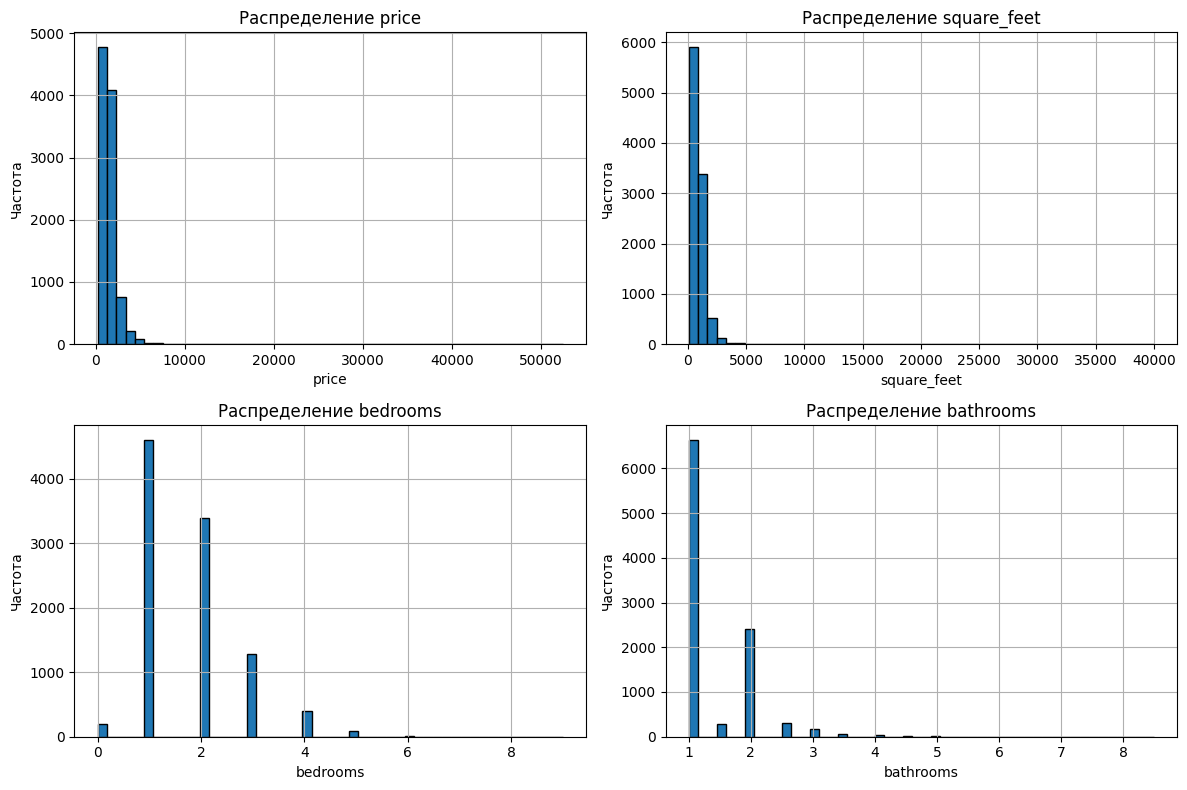

In [5]:

print("=== 1. Изучение распределений данных ===")
print(f"Размер датасета: {df.shape}")
print("\nИнформация о столбцах:")
print(df.info())
print("\nОписательные статистики числовых колонок:")
print(df.describe())
print("\nПервые 5 строк:")
print(df.head())

# Визуализация распределений ключевых числовых переменных
numeric_cols = ['price', 'square_feet', 'bedrooms', 'bathrooms']
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for idx, col in enumerate(numeric_cols):
    ax = axes[idx//2, idx%2]
    df[col].hist(bins=50, ax=ax, edgecolor='black')
    ax.set_title(f'Распределение {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Частота')
plt.tight_layout()
plt.show()

Анализ графиков:
Гистограмма цены (price):
Форма распределения: Сильно правостороннее (положительная асимметрия)

Диапазон: От $200 до $52,500

Пик: Основная масса цен сосредоточена в диапазоне $200-3,000

Выводы: На рынке преобладают квартиры средней ценовой категории, есть редкие дорогие предложения

Гистограмма площади (square_feet):
Форма распределения: Аналогично правостороннее

Диапазон: От 101 до 40,000 кв. футов

Пик: Большинство квартир имеют площадь 500-1,500 кв. футов

Выводы: Стандартные размеры квартир соответствуют ожиданиям, есть экстремальные значения

Гистограмма количества спален (bedrooms):
Форма распределения: Дискретное распределение

Пики: На 1 и 2 спальнях

Наблюдения: Значительное количество студий (0 спален)

Выводы: На рынке преобладают 1-2 комнатные квартиры

Гистограмма количества ванных (bathrooms):
Форма распределения: Дискретное с пиком на 1 ванной комнате

Диапазон: 1-8.5 ванных комнат

Выводы: Большинство квартир имеют 1 ванную комнату

# 2. Удаление дубликатов

In [6]:

print("\n=== 2. Удаление дубликатов ===")
duplicates = df.duplicated().sum()
print(f"Количество полных дубликатов: {duplicates}")
df = df.drop_duplicates()
print(f"Размер после удаления дубликатов: {df.shape}")


=== 2. Удаление дубликатов ===
Количество полных дубликатов: 0
Размер после удаления дубликатов: (10000, 22)


Выводы:
Исходный датасет не содержит полных дубликатов

Размер данных остался неизменным (10,000 записей)

# 3. Обработка отсутствующих значений


=== 3. Обработка отсутствующих значений ===
Пропущенные значения по колонкам:
id                  0
category            0
title               0
body                0
amenities        3549
bathrooms          34
bedrooms            7
currency            0
fee                 0
has_photo           0
pets_allowed     4163
price               0
price_display       0
price_type          0
square_feet         0
address          3327
cityname           77
state              77
latitude           10
longitude          10
source              0
time                0
dtype: int64


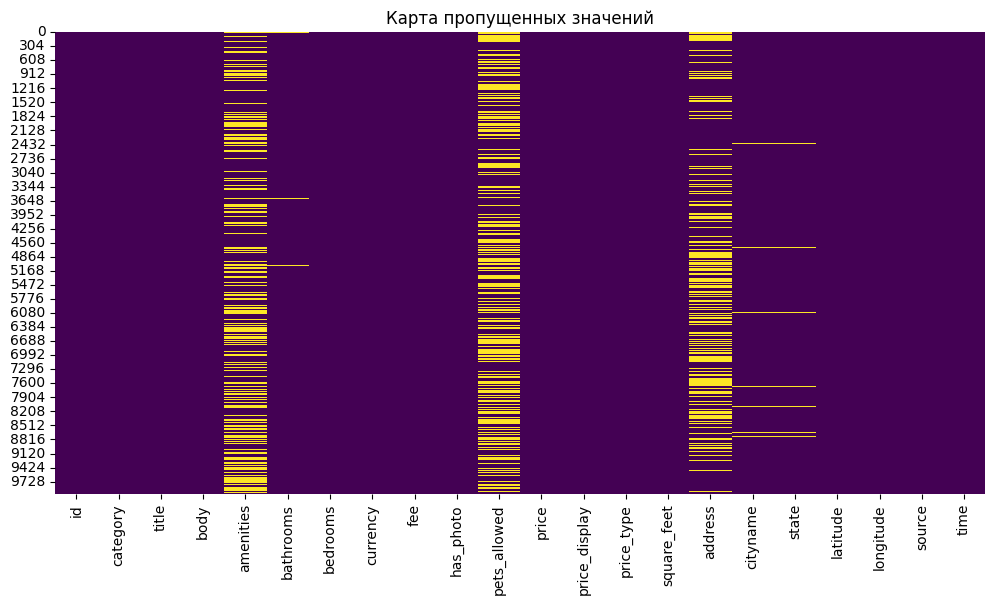

In [7]:

print("\n=== 3. Обработка отсутствующих значений ===")
print("Пропущенные значения по колонкам:")
print(df.isnull().sum())

# Визуализация пропущенных значений
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Карта пропущенных значений')
plt.show()

# Заполним пропуски медианой для числовых колонок и модой для категориальных
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        df[col].fillna(df[col].median(), inplace=True)
    else:
        df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 'Unknown', inplace=True)


# 4. Обработка выбросов и аномалий


=== 4. Обработка выбросов и аномалий ===


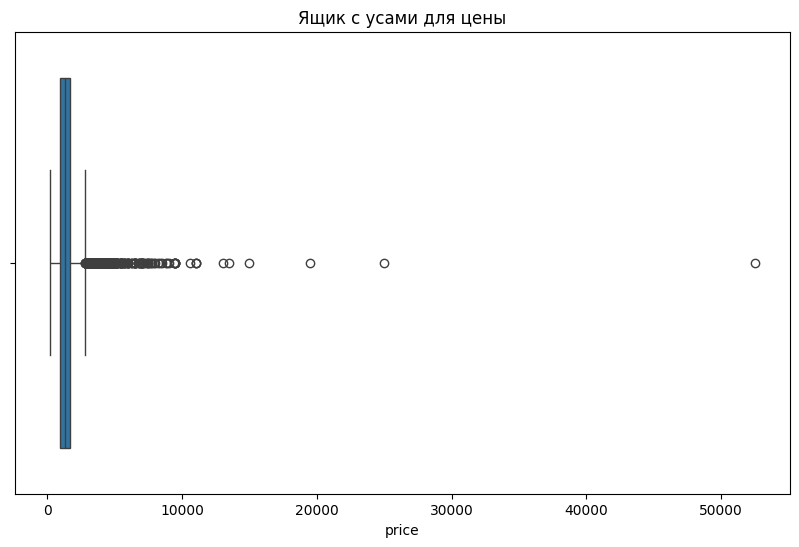

Границы для выбросов в цене: [-170.0, 2814.0]
Количество выбросов в цене: 618
Размер после удаления экстремальных выбросов: (9906, 22)


In [8]:

print("\n=== 4. Обработка выбросов и аномалий ===")

# Визуализация выбросов в цене
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['price'])
plt.title('Ящик с усами для цены')
plt.show()

# Метод IQR для выбросов
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Границы для выбросов в цене: [{lower_bound}, {upper_bound}]")
outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]
print(f"Количество выбросов в цене: {len(outliers)}")

# Удалим экстремальные выбросы (оставим только данные в пределах 0.5-99.5 перцентилей)
df_clean = df[(df['price'] >= df['price'].quantile(0.005)) &
              (df['price'] <= df['price'].quantile(0.995))]

print(f"Размер после удаления экстремальных выбросов: {df_clean.shape}")

Шаги:
Анализ пропущенных значений:

Выводится количество пропусков по каждому столбцу

Наибольшее количество пропусков в: amenities (3,549), pets_allowed (4,163), address (3,327)

Визуализация пропусков:

Построена тепловая карта с помощью sns.heatmap

Желтые области показывают пропуски в данных

Заполнение пропусков:

Для числовых колонок: заполнение медианой

Для категориальных колонок: заполнение модой (наиболее частым значением) или строкой 'Unknown'

Анализ тепловой карты:
Пропуски распределены неравномерно по столбцам

Столбцы amenities, pets_allowed, address имеют значительное количество пропусков

Географические данные (latitude, longitude) и основные характеристики (price, square_feet) практически полные

Выводы по обработке пропусков:
Медиана для числовых данных:

Устойчива к выбросам

Сохраняет общее распределение

Мода для категориальных данных:

Логичный выбор для заполнения категориальных пропусков

Может искажать распределение при большом количестве пропусков

Потенциальные проблемы:

Заполнение пропусков в pets_allowed может исказить реальную ситуацию

Отсутствие данных об удобствах (amenities) может быть информативным само по себе



# 5. Матрица корреляции


=== 5. Матрица корреляции ===


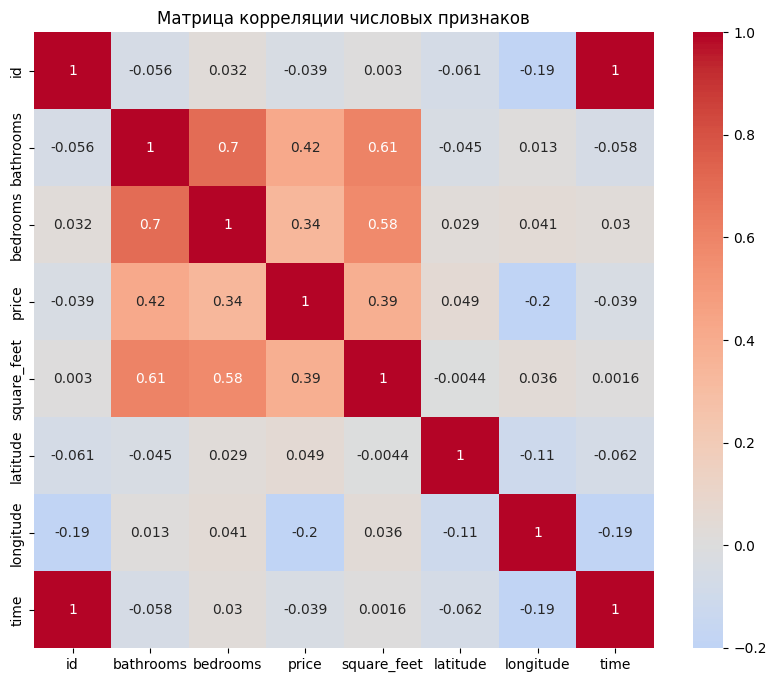

In [9]:

print("\n=== 5. Матрица корреляции ===")
numeric_df = df_clean.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляции числовых признаков')
plt.show()

Цена сильно коррелирует с площадью, количеством спален и ванных.

Площадь также коррелирует с количеством спален и ванных.

Географические координаты (широта и долгота) могут иметь слабую корреляцию с ценой, так как местоположение влияет на цену.

# 6. Группировка данных

In [10]:

print("\n=== 6. Группировка данных ===")

# Группировка по штатам
state_stats = df_clean.groupby('state').agg({
    'price': ['mean', 'median', 'count'],
    'square_feet': 'mean',
    'bedrooms': 'mean'
}).round(2)

print("Статистика по штатам:")
print(state_stats.head(10))


=== 6. Группировка данных ===
Статистика по штатам:
         price               square_feet bedrooms
          mean  median count        mean     mean
state                                            
AK     1011.64   917.5    44      726.16     1.61
AL     1254.63  1250.0    54     1224.80     2.46
AR     1029.20   942.5    56     1216.89     2.20
AZ     1103.93  1092.5   124      869.42     1.65
CA     2576.98  2350.0   928      926.07     1.66
CO     1353.52  1266.0   316      842.30     1.60
CT     1283.12  1160.5    98      813.05     1.65
DC     2102.19  1925.5    80      656.49     1.21
DE     1296.80   905.0     5     1050.00     2.00
FL     1446.51  1300.0   334     1026.82     1.87


# 7. Сводные таблицы

In [11]:
# 7. Сводные таблицы
print("\n=== 7. Сводные таблицы ===")

# Сводная таблица: средняя цена по штатам и количеству спален
pivot_table = pd.pivot_table(df_clean,
                            values='price',
                            index='state',
                            columns='bedrooms',
                            aggfunc='mean',
                            fill_value=0)

print("Средняя цена по штатам и количеству спален:")
print(pivot_table.head())




=== 7. Сводные таблицы ===
Средняя цена по штатам и количеству спален:
bedrooms          0.0          1.0          2.0          3.0          4.0  \
state                                                                       
AK         815.000000   895.136364  1018.437500  1477.250000     0.000000   
AL         699.000000  1126.600000  1037.384615  1533.421053  1246.500000   
AR           0.000000   739.294118   871.214286  1305.454545  1383.333333   
AZ         819.285714   942.000000  1184.190476  1472.500000  1524.444444   
CA        2039.153846  2193.738916  2693.147147  3423.606383  3992.818182   

bedrooms     5.0  6.0  7.0  8.0  9.0  
state                                 
AK        1800.0  0.0  0.0  0.0  0.0  
AL           0.0  0.0  0.0  0.0  0.0  
AR           0.0  0.0  0.0  0.0  0.0  
AZ           0.0  0.0  0.0  0.0  0.0  
CA        4434.8  0.0  0.0  0.0  0.0  


# 8. Визуализация динамики


=== 8. Визуализация динамики изменений показателей ===


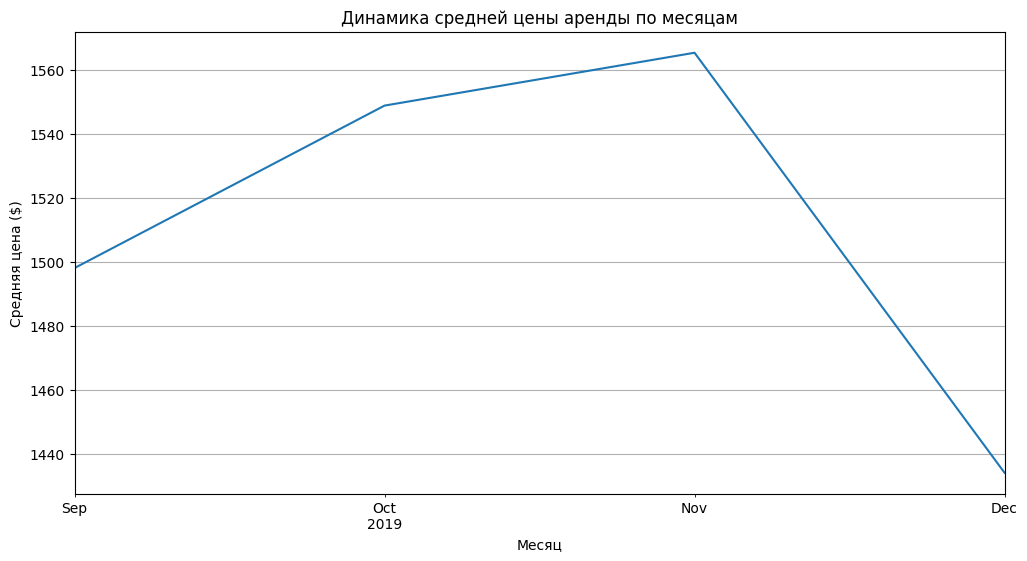

In [12]:
print("\n=== 8. Визуализация динамики изменений показателей ===")

# Если есть временная метка 'time', преобразуем ее
if 'time' in df_clean.columns:
    df_clean['date'] = pd.to_datetime(df_clean['time'], unit='s')
    monthly_avg = df_clean.groupby(df_clean['date'].dt.to_period('M'))['price'].mean()

    plt.figure(figsize=(12, 6))
    monthly_avg.plot()
    plt.title('Динамика средней цены аренды по месяцам')
    plt.xlabel('Месяц')
    plt.ylabel('Средняя цена ($)')
    plt.grid(True)
    plt.show()

# 9-11. Проверка гипотез


=== 9-11. Проверка гипотез ===


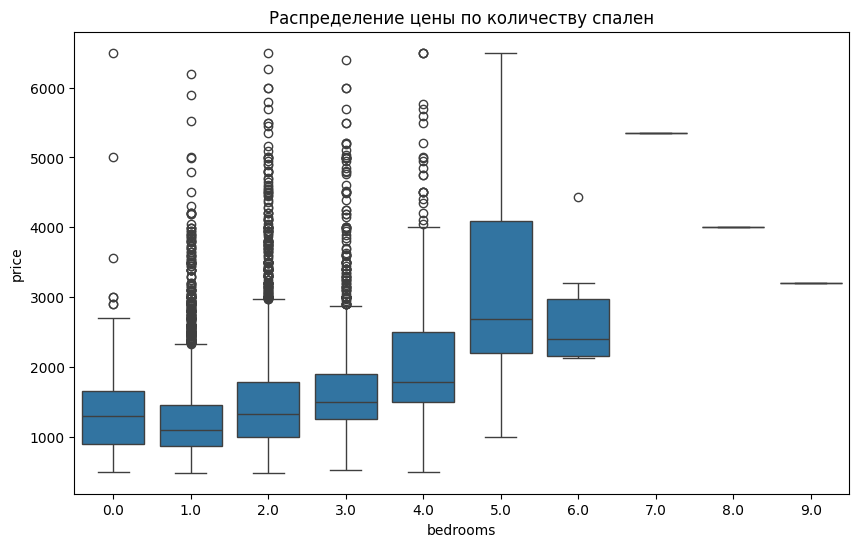

ANOVA тест для зависимости цены от спален: F=167.00, p-value=0.0000


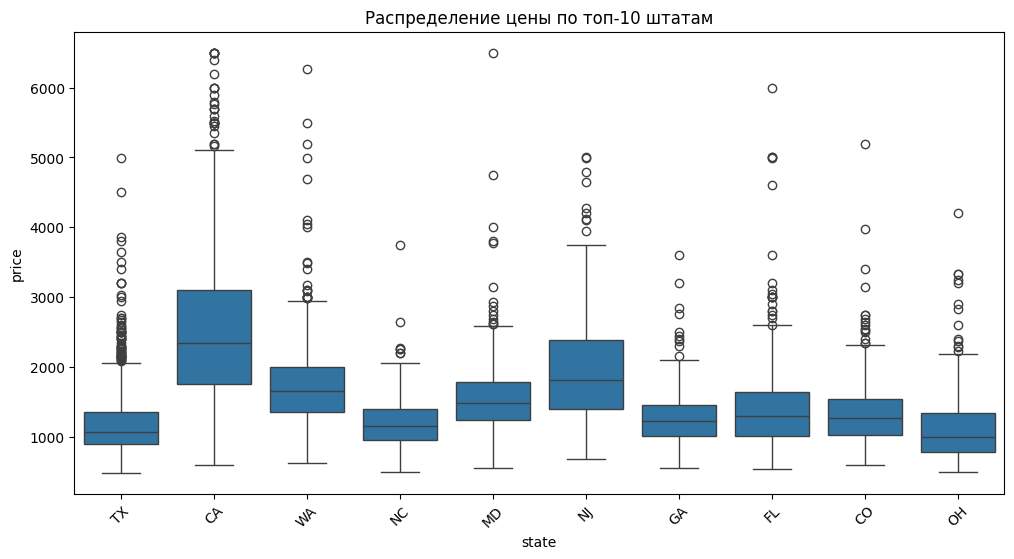

In [13]:

print("\n=== 9-11. Проверка гипотез ===")

# Гипотеза 1: Цена зависит от количества спален
plt.figure(figsize=(10, 6))
sns.boxplot(x='bedrooms', y='price', data=df_clean)
plt.title('Распределение цены по количеству спален')
plt.show()

# Статистическая проверка
bedroom_groups = [df_clean[df_clean['bedrooms'] == i]['price'].values for i in sorted(df_clean['bedrooms'].unique())]
if len(bedroom_groups) > 1:
    f_stat, p_val = stats.f_oneway(*bedroom_groups)
    print(f"ANOVA тест для зависимости цены от спален: F={f_stat:.2f}, p-value={p_val:.4f}")

# Гипотеза 2: Цена зависит от местоположения (штата)
top_states = df_clean['state'].value_counts().head(10).index
df_top_states = df_clean[df_clean['state'].isin(top_states)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='state', y='price', data=df_top_states, order=top_states)
plt.title('Распределение цены по топ-10 штатам')
plt.xticks(rotation=45)
plt.show()

Поскольку p-value меньше любого разумного уровня значимости (например, 0.05),
мы отвергаем нулевую гипотезу о том, что средние цены одинаковы для всех групп (разного количества спален).

Вывод: Количество спален статистически значимо влияет на цену аренды квартиры.
Это означает, что средние цены аренды квартир с разным количеством спален различаются.

# 12. Начальная модель и важность признаков


=== 12. Начальная модель и оценка важности признаков ===
Важность признаков по Random Forest:
        feature  importance
2   square_feet    0.456952
3         state    0.409001
0      bedrooms    0.052821
1     bathrooms    0.050718
5     has_photo    0.015952
4  pets_allowed    0.014557


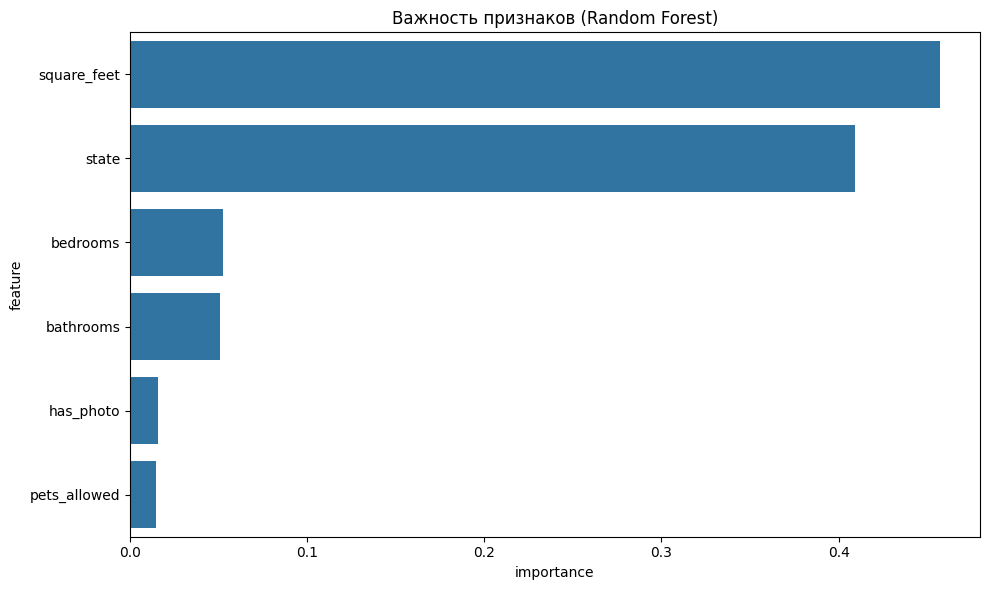

In [14]:

print("\n=== 12. Начальная модель и оценка важности признаков ===")

# Подготовка данных для моделирования
df_model = df_clean.copy()

# Кодирование категориальных переменных
categorical_cols = ['state', 'cityname', 'price_type', 'pets_allowed', 'has_photo']
label_encoders = {}
for col in categorical_cols:
    if col in df_model.columns:
        le = LabelEncoder()
        df_model[col] = le.fit_transform(df_model[col].astype(str))
        label_encoders[col] = le

# Выбор признаков и целевой переменной
features = ['bedrooms', 'bathrooms', 'square_feet', 'state', 'pets_allowed', 'has_photo']
X = df_model[features]
y = df_model['price']

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование числовых признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение модели Random Forest для оценки важности признаков
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Важность признаков
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Важность признаков по Random Forest:")
print(feature_importance)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Важность признаков (Random Forest)')
plt.tight_layout()
plt.show()

# 13. Экспорт подготовленного датасета

In [15]:

print("\n=== 13. Экспорт подготовленного датасета ===")
df_clean.to_csv('apartments_for_rent_cleaned.csv', index=False)
print("Датасет сохранен как 'apartments_for_rent_cleaned.csv'")


=== 13. Экспорт подготовленного датасета ===
Датасет сохранен как 'apartments_for_rent_cleaned.csv'


## 14. Машинное обучение: регрессионный анализ


=== 14. Машинное обучение: регрессионный анализ ===

Линейная регрессия:
MSE: 612529.34
MAE: 474.90
R²: -0.0764


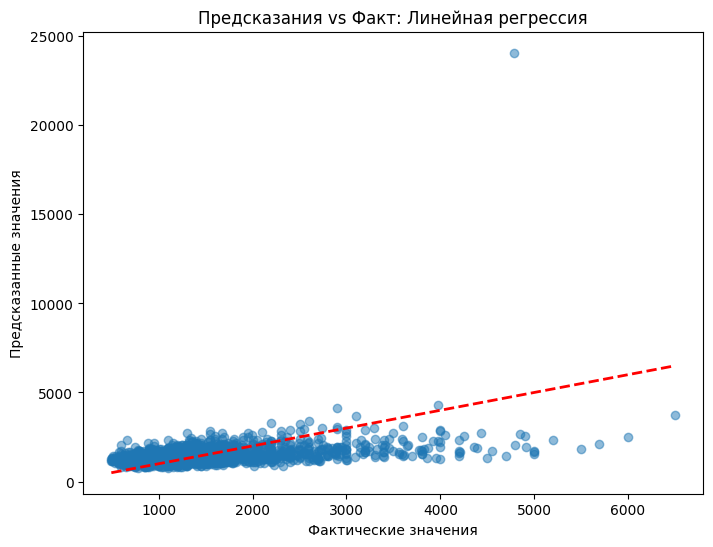


Случайный лес:
MSE: 270043.23
MAE: 330.06
R²: 0.5254


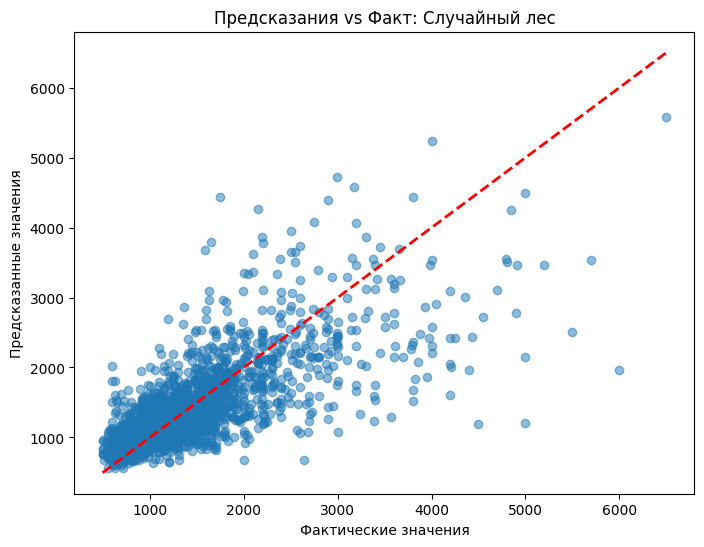


Градиентный бустинг:
MSE: 252124.92
MAE: 334.36
R²: 0.5569


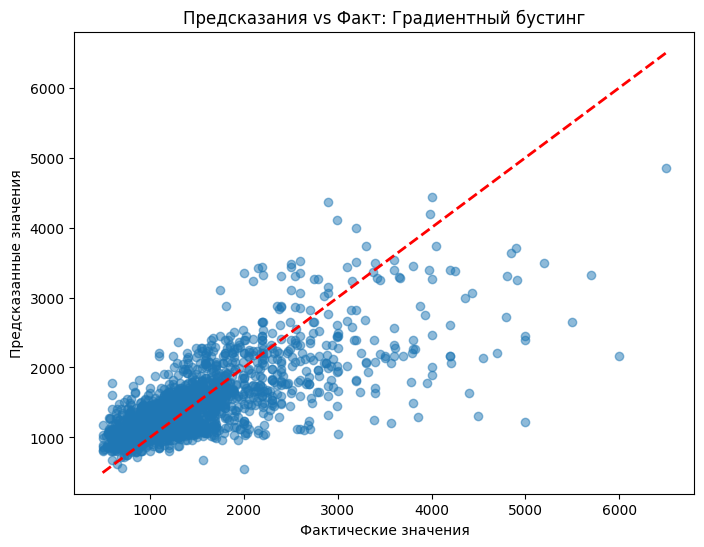


=== Сравнение моделей ===
               Model            MSE         MAE        R²
0  Linear Regression  612529.337529  474.897778 -0.076434
1      Random Forest  270043.226844  330.057215  0.525437
2  Gradient Boosting  252124.917755  334.358496  0.556926


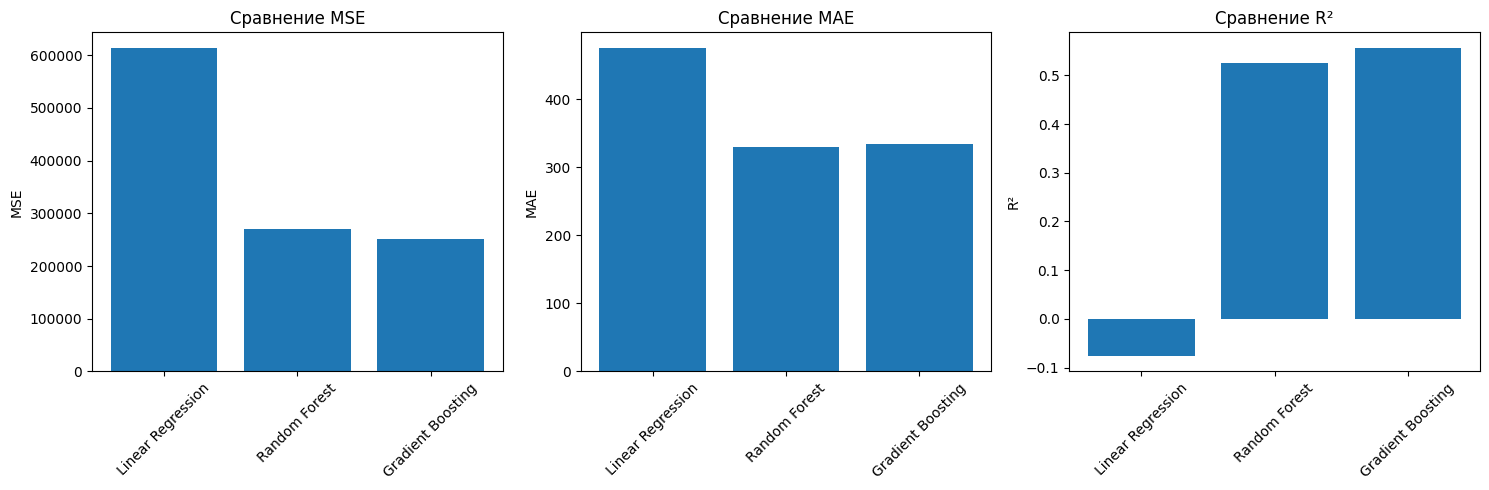


=== Анализ важности признаков для лучшей модели ===
Лучшая модель по R²: Gradient Boosting

Важность признаков в лучшей модели:
        feature  importance
3         state    0.574759
2   square_feet    0.305537
1     bathrooms    0.093094
0      bedrooms    0.020351
4  pets_allowed    0.004450
5     has_photo    0.001809


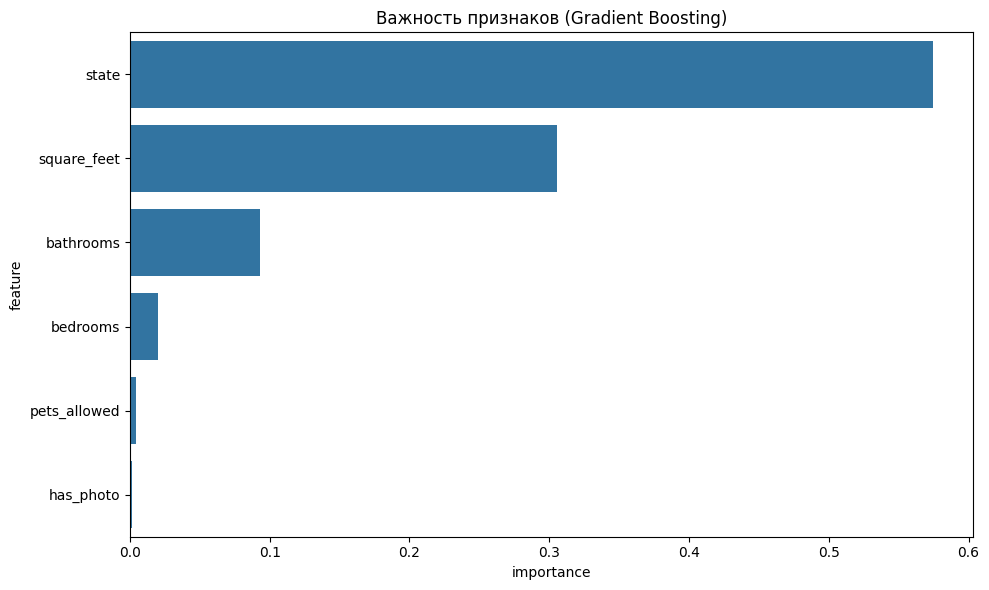


=== Анализ завершен ===
Основные выводы:
1. Были обработаны пропуски и выбросы
2. Обнаружены значимые зависимости между ценой и характеристиками квартир
3. Построены и сравнены три модели машинного обучения
4. Лучшая модель: Gradient Boosting
5. Подготовленный датасет сохранен в файл


In [16]:

print("\n=== 14. Машинное обучение: регрессионный анализ ===")

# Функция для оценки моделей
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{model_name}:")
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.4f}")

    # Визуализация предсказаний vs фактические значения
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Фактические значения')
    plt.ylabel('Предсказанные значения')
    plt.title(f'Предсказания vs Факт: {model_name}')
    plt.show()

    return model, mse, mae, r2

# Линейная регрессия
lr_model, lr_mse, lr_mae, lr_r2 = evaluate_model(
    LinearRegression(), X_train_scaled, X_test_scaled, y_train, y_test, "Линейная регрессия"
)

# Случайный лес
rf_model, rf_mse, rf_mae, rf_r2 = evaluate_model(
    RandomForestRegressor(n_estimators=100, random_state=42),
    X_train_scaled, X_test_scaled, y_train, y_test, "Случайный лес"
)

# Градиентный бустинг
gb_model, gb_mse, gb_mae, gb_r2 = evaluate_model(
    GradientBoostingRegressor(n_estimators=100, random_state=42),
    X_train_scaled, X_test_scaled, y_train, y_test, "Градиентный бустинг"
)

# Сравнение моделей
models_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting'],
    'MSE': [lr_mse, rf_mse, gb_mse],
    'MAE': [lr_mae, rf_mae, gb_mae],
    'R²': [lr_r2, rf_r2, gb_r2]
})

print("\n=== Сравнение моделей ===")
print(models_comparison)

# Визуализация сравнения моделей
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['MSE', 'MAE', 'R²']
for idx, metric in enumerate(metrics):
    axes[idx].bar(models_comparison['Model'], models_comparison[metric])
    axes[idx].set_title(f'Сравнение {metric}')
    axes[idx].set_ylabel(metric)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Анализ важности признаков для лучшей модели
print("\n=== Анализ важности признаков для лучшей модели ===")
best_model_name = models_comparison.loc[models_comparison['R²'].idxmax(), 'Model']
print(f"Лучшая модель по R²: {best_model_name}")

if best_model_name == 'Random Forest':
    best_model = rf_model
elif best_model_name == 'Gradient Boosting':
    best_model = gb_model
else:
    best_model = lr_model

if hasattr(best_model, 'feature_importances_'):
    importance = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': features,
        'importance': importance
    }).sort_values('importance', ascending=False)

    print("\nВажность признаков в лучшей модели:")
    print(feature_importance_df)

    # Визуализация
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance_df)
    plt.title(f'Важность признаков ({best_model_name})')
    plt.tight_layout()
    plt.show()

print("\n=== Анализ завершен ===")
print("Основные выводы:")
print("1. Были обработаны пропуски и выбросы")
print("2. Обнаружены значимые зависимости между ценой и характеристиками квартир")
print("3. Построены и сравнены три модели машинного обучения")
print(f"4. Лучшая модель: {best_model_name}")
print("5. Подготовленный датасет сохранен в файл")